# Solving First Order Differential Equation with Hybrid PINN
## Case Study: Fatigue Crack Propagation 
### Theory

$\frac{da}{dN}=C(\Delta K (t))^m$ where $\Delta K(t) = F\Delta S(t) \sqrt{\pi a(t)}$

where
* a: fatigue crack length
* C and m: material properties coeff
* $\Delta k$: stress intensity rages
* $\Delta s$: far-field cyclic stress time histroy
* F: dimensionless function of geometry

Let us numericaly solve the equation ($\Delta k$) with hybrid method!

Use Euler's forward method
* $a_{n} = a_{0} + \Sigma_{t=1}^{n} \Delta a(\Delta S_{t}, a_{t-1})$
* $\Delta a_t = C \Delta K_{t}^m$
* $\Delta K_t = MLP(\Delta S_t, a_{t-1}; \boldsymbol{w}, \boldsymbol{b})$

The loss function is MSE
* $\Lambda = \frac{1}{n} (\boldsymbol{a}-\boldsymbol{\hat{a}})^T(\boldsymbol{a}-\boldsymbol{\hat{a}})$

$\boldsymbol{a}$ are fatigue crack length.
$\boldsymbol{\hat{a}}$ are predicted value.

### Import the Libraries

In [123]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import RNN, Dense, Layer, Input
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.framework import tensor_shape
from tensorflow import float32, concat, convert_to_tensor
from tensorflow.keras.callbacks import ModelCheckpoint

### Define Cells and Useful Function

In [124]:
class EulerIntegratorCell(Layer):
    def __init__(self, C, m, dKlayer, a0=None, units=1, batch_input_shape=None, **kwargs):
        super(EulerIntegratorCell, self).__init__(**kwargs)
        self.units = units
        self.C = C
        self.m = m
        self.dKlayer = dKlayer
        self.a0 = a0
        self.state_size = self.units
        self.output_size = self.units

    def build(self, input_shape, **kwargs):
        self.built = True

    def call(self, inputs, states):
        inputs = convert_to_tensor(inputs)
        a_tm1 = convert_to_tensor(states)
        x_d_tm1 = concat((inputs, a_tm1[0, :]), axis=1)
        dk_t = self.dKlayer(x_d_tm1)
        da_t = self.C * (dk_t ** self.m)
        a = da_t + a_tm1[0, :]
        return a, [a]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.a0

In [125]:
class Normalization(Layer):
    def __init__(self, S_low, S_up, a_low, a_up, **kwargs):
        super(Normalization, self).__init__(**kwargs)
        print(kwargs)
        self.lower_bound_S = S_low
        self.upper_bound_S = S_up
        self.lower_bound_a = a_low
        self.upper_bound_a = a_up

    def build(self, input_shape, **kwargs):
        self.built = True

    def call(self, inputs):
        output = (inputs - [self.lower_bound_S, self.upper_bound_a]) / [(self.upper_bound_S - self.lower_bound_S), (self.upper_bound_a - self.lower_bound_a)]
        return output

In [126]:
def create_model(C, m, a0, dKlayer, batch_input_shape, return_sequences=False, return_state=False):
    euler = EulerIntegratorCell(C=C, m=m, dKlayer=dKlayer, a0=a0, batch_input_shape=batch_input_shape)
    PINN = RNN(cell=euler, return_sequences=return_sequences, return_state=return_state)
    model = Sequential()
    model.add(Input(batch_shape=batch_input_shape))
    model.add(PINN)
    model.compile(loss='mse', optimizer=RMSprop(1e-2))
    return model

### Load Data

In [127]:
# Paris law coefficients
[C, m] = [1.5E-11, 3.8]

# Load Data
Strain = np.asarray(pd.read_csv('./data/Strain.csv'))[:,:,np.newaxis]
atrain = np.asarray(pd.read_csv('./data/atrain.csv'))
a0 = np.asarray(pd.read_csv('./data/a0.csv'))[0,0]*np.ones((Strain.shape[0], 1))

### Fit and Predict

In [128]:
# stress-intensity layer
dKlayer = Sequential()
dKlayer.add(Normalization(np.min(Strain), np.max(Strain), np.min(atrain), np.max(atrain)))
dKlayer.add(Dense(5, activation='tanh'))
dKlayer.add(Dense(1))

# weight initilization
S_range = np.linspace(np.min(Strain), np.max(Strain), 1000)
a_range = np.linspace(np.min(atrain), np.max(atrain), 1000)[np.random.permutation(np.arange(1000))]
dK_range = -12.05 + 0.24 * S_range + 760.0 * a_range

dKlayer.compile(loss='mse', optimizer=RMSprop(1e-2))
input_train = np.transpose(np.asarray([S_range, a_range]))
dKlayer.fit(input_train, dK_range, epochs=100, verbose=0)

# Fitting PINN
model = create_model(C=C, m=m, a0=convert_to_tensor(a0, dtype=float32), dKlayer=dKlayer, batch_input_shape=Strain.shape)
aPred_before = model.predict_on_batch(Strain)[:,:]
# To plot loss curve, set histroy and fit
history = model.fit(Strain, atrain, epochs=100, steps_per_epoch=1, verbose=1)
aPred = model.predict_on_batch(Strain)[:,:]

{}
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 7.6812e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 3/100


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - loss: 6.0841e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - loss: 4.9473e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - loss: 3.9756e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - loss: 3.0960e-04
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - loss: 2.2820e-04
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - loss: 1.5707e-04
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - loss: 9.5754e-05
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1

### Results (Train)

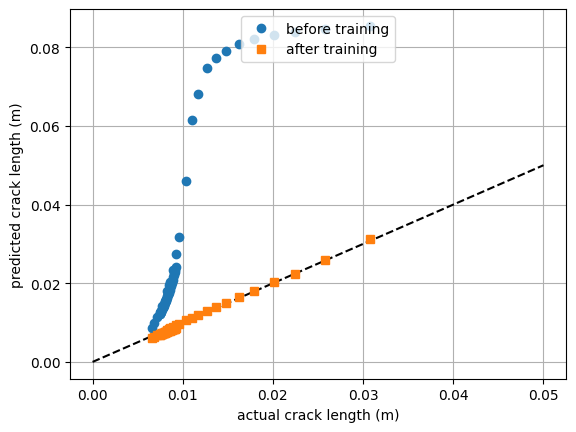

In [129]:
# Plotting prediction
fig = plt.figure()
plt.plot([0,0.05],[0,0.05],'--k')
plt.plot(atrain, aPred_before, 'o', label = 'before training')
plt.plot(atrain, aPred, 's', label = 'after training')
plt.xlabel("actual crack length (m)")
plt.ylabel("predicted crack length (m)")
plt.legend(loc = 'upper center',facecolor = 'w')
plt.grid(which='both')
plt.show()
    

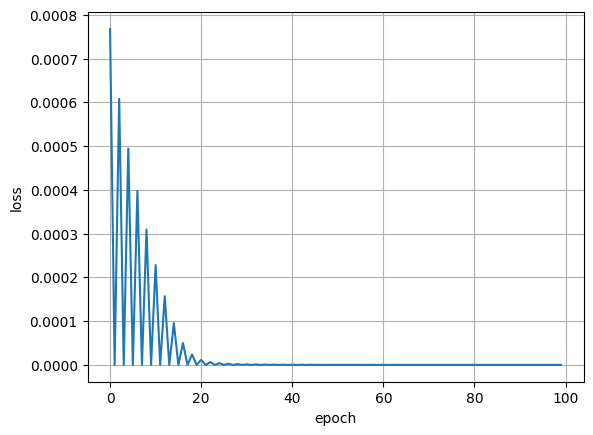

In [130]:
# plotting loss curve
fig = plt.figure()
plt.plot(np.array(history.history['loss']))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(which='both')
plt.show()


### Train the Model for the Test

{}
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 6.0343e-04
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0000e+00
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - loss: 4.6730e-04
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 3.6731e-04
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step - loss: 2.8079e-04
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step - loss: 2.0247e-04
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - loss: 1.3521e-04
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - loss: 7.8248e-05
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 15/100
1/1 ━━━━━━━━━━━

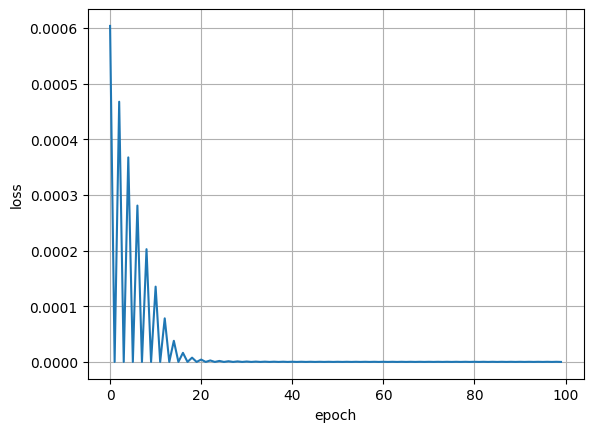

In [131]:
# stress-intensity layer
dKlayer = Sequential()
dKlayer.add(Normalization(70, 160, 0.005, 0.03))
dKlayer.add(Dense(5, activation='tanh'))
dKlayer.add(Dense(1))

# weight initialization
S_range  = np.linspace(70, 160, 1000)
a_range  = np.linspace(0.005, 0.03, 1000)[np.random.permutation(np.arange(1000))]
dK_range = -12.05 + 0.24 * S_range + 760.0 * a_range

dKlayer.compile(loss='mse', optimizer=RMSprop(1e-2))
inputs_train = np.transpose(np.asarray([S_range, a_range]))
dKlayer.fit(inputs_train, dK_range, epochs=100, verbose=0)

# fitting physics-informed neural network
mckp = ModelCheckpoint(filepath = "./savedmodels/cp.weights.h5", monitor = 'loss', verbose = 0,
                        save_best_only = True, mode = 'min', save_weights_only = True)

model = create_model(C=C, m=m, a0=convert_to_tensor(a0, dtype=float32), dKlayer=dKlayer, batch_input_shape=Strain.shape)
history = model.fit(Strain, atrain, epochs=100, steps_per_epoch=1, verbose=1, callbacks=[mckp])

# plotting predictions
fig = plt.figure()
plt.plot(np.array(history.history['loss']))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(which='both')
plt.show()


### Result (Test)

In [132]:
Stest = np.asarray(pd.read_csv('./data/Stest.csv'))[:, :, np.newaxis]
atest = np.asarray(pd.read_csv('./data/atest.csv'))
a0    = np.asarray(pd.read_csv('./data/a0.csv'))[0,0]*np.ones((Stest.shape[0],1))

# stress-intensity layer
dKlayer = Sequential()
dKlayer.add(Normalization(70, 160, 0.005, 0.03))
dKlayer.add(Dense(5, activation='tanh'))
dKlayer.add(Dense(1))

# weight initialization
S_range  = np.linspace(70, 160, 1000)
a_range  = np.linspace(0.005, 0.03, 1000)[np.random.permutation(np.arange(1000))]
dK_range = -12.05 + 0.24 * S_range + 760.0 * a_range

dKlayer.compile(loss='mse', optimizer=RMSprop(1e-2))
inputs_train = np.transpose(np.asarray([S_range, a_range]))
dKlayer.fit(inputs_train, dK_range, epochs=100, verbose=0)

# building the model and predicting before "training"
model = create_model(C=C, m=m, a0=convert_to_tensor(a0, dtype=float32),
                        dKlayer=dKlayer, return_sequences=True, batch_input_shape=Stest.shape)
aBefore = model.predict_on_batch(Stest)[:,:,0]

# loading weights from trained model
model.load_weights("./savedmodels/cp.weights.h5")
aAfter = model.predict_on_batch(Stest)[:,:,0]

{}


C:\Users\Issei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


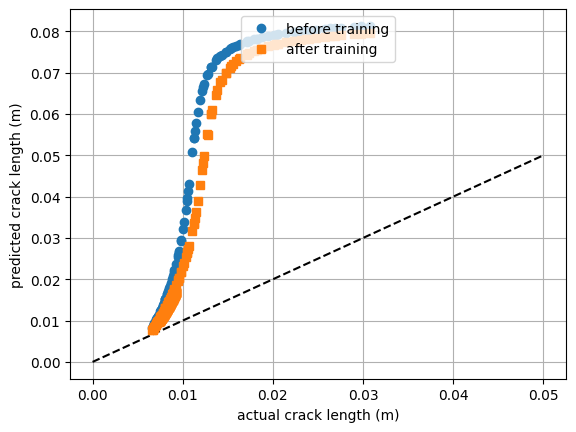

In [133]:
fig = plt.figure()
plt.plot([0,0.05],[0,0.05],'--k')
plt.plot(atest[:,-1],aBefore[:,-1],'o', label = 'before training')
plt.plot(atest[:,-1],aAfter[:,-1], 's', label = 'after training')
plt.xlabel("actual crack length (m)")
plt.ylabel("predicted crack length (m)")
plt.legend(loc = 'upper center',facecolor = 'w')
plt.grid(which='both')
plt.show()

### Reference

1. Nascimento, R. G., Fricke, K., Marques, A. D., & Viana, F. A. C. (2020). *A tutorial on solving ordinary differential equations using Python and hybrid physics-informed neural networks*. Engineering Applications of Artificial Intelligence, 96, 103996. [https://doi.org/10.1016/j.engappai.2020.103996](https://doi.org/10.1016/j.engappai.2020.103996)

   GitHub Repository: [https://github.com/PML-UCF/pinn_ode_tutorial](https://github.com/PML-UCF/pinn_ode_tutorial)